In [1]:
# Using uncalibrated airplane data, generate baseline and antenna calibrations for a given day
#
# Author: Brian Pitzel
# Date Created: 3 March 2025
# Date Modified: 1 May 2025

import numpy as np
import h5py 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap # cyclic colormap
import colorcet as cc # cyclic colormap
from matplotlib.lines import Line2D
import datetime
import csv
import glob
import pickle
import pymap3d as pm
from datetime import timezone
import warnings
import helpers.airplanes as ap
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib widget

vfromtimestamp = np.vectorize(datetime.datetime.fromtimestamp)
vutcfromtimestamp = np.vectorize(datetime.datetime.utcfromtimestamp)

In [2]:
# hard-coded magic numbers needed for the script

N_BASELINES = 45

# download aircraft data only if it falls within these lat/lon boundaries
# west, south, east, north
BOUNDS = (-109.375, 50.771, -106.0, 52.765) # old bounds
BOUNDS = (-109.375, 50.8, -106.4, 52.25) # new bounds, more constrained

# locations of the ICEBEAR receiver and transmitter
RX = (52.24393, -106.45025, 0)
TX = (50.893, -109.403, 0)
TX_RX_DISTANCE = 254 # km

# convert feet to meters
FT_TO_M = 1 / 3.281


# plotting stuff
fig_width_inches = 8#17
fig_height_inches = 5#10
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

SMALL_SIZE = 20 #38
MEDIUM_SIZE = 25 #42
BIGGER_SIZE = 35 #56

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE//2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# inputs to the script:
# ymd - date of the day to calibrate on (will use data from all 24 hours unless otherwise specified)
# level1_files - UNCALIBRATED level 1 data (range correction applied, NO rx calibration applied)

year = 2024
month = 7
day = 1

# don't change these unless you want specific hours included/excluded
h = 0
n_hours = 24
level1_files = []
for i in range(n_hours):
    level1_files.append(f'/mnt/NAS/range-corrected-data/L1-no-cal/{year}/{month:02d}/{year}_{month:02d}_{day:02d}/ib3d_normal_01dB_1000ms_{year}_{month:02d}_{day:02d}_{(h+i):02d}_prelate_bakker.h5')

In [4]:
# unleash the beast

In [5]:
# first, find all of the airplane echoes in the level1_data.
# this allows us to pull airplane data at the proper times, instead of pulling ALL data from the entire day

t_start = datetime.datetime(year, month, day, 0, 0, 0, tzinfo=timezone.utc)
t_end = datetime.datetime(year, month, day, 23, 59, 59, tzinfo=timezone.utc)

airplane_xspectra, airplane_spectra, airplane_echo_time = ap.load_level1_airplane_xspectra(level1_files, t_start, t_end)

2024-07-01 00:00:00+00:00 2024-07-01 23:59:59+00:00
(22625, 45)


In [19]:
# now, for all of the timestamps at which there is airplane echoes, load in the airplane data.
# if there is a filtered aircraft_db, use it. Otherwise, look for a non-filtered db.
# if there is no db at all, download it.
time_filter = np.ones(airplane_echo_time.shape, dtype=np.bool)
unique_filtered = False
try:
    aircrafts_dbs = ap.load_airplane_data(f'filtered_aircraft/aircrafts_dbs_filtered_{year:04d}-{month:02d}-{day:02d}-unique.pckl')
    unique_filtered = True
except:
    try:
        aircrafts_dbs = ap.load_airplane_data(f'filtered_aircraft/aircrafts_dbs_filtered_{year:04d}-{month:02d}-{day:02d}.pckl')
    except:
        try:
            aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
            aircrafts_dbs = ap.filter_aircraft_db(aircrafts_dbs, airplane_xspectra, airplane_echo_time)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=True)
        except:
            aircrafts_dbs = ap.retrieve_airplane_data(airplane_echo_time, time_filter, BOUNDS)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=False)
            aircrafts_dbs = ap.filter_aircraft_db(aircrafts_dbs, airplane_xspectra, airplane_echo_time)
            ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}', filtered=True)

In [7]:
%%script false --no-raise-error

# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase
# also make a sample plot to assist in picking out the good airplanes

# TODO: FIGURE OUT WHY THIS CHUNK IS SO MUCH SLOWER THAN THE NEXT CHUNK

baseline_to_plot = [1, 5]

fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Baseline Phase [deg]')
ax.set_xlabel('Time ')
ax.set_title(f'Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]}')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid()

# count the airplanes to know the size of the arrays we need
n_airplanes = 0
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
                
    # db[i].data.long/lat is the time series of data for one airplane (i)            
    for i in range(len(db)): # db[i] is a single airplane
        n_airplanes += 1

total_phases = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)
S_array = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)
slopes_array = np.ndarray((n_airplanes, N_BASELINES), dtype=np.float32)


airplane_idx = 0
for db in aircrafts_dbs:
     # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe
        print(f'airplane {airplane_idx}')
        # indexes in db contain multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]
            
        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        tf = db[i].data.timestamp[end_idx]

        # we don't want to look at the short airplanes
        if end_idx - start_idx <= 6:
            total_phases[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue

        # or the short airplanes
        if np.mean(db[i].data.altitude * FT_TO_M) < 5000:
            total_phases[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        az = -az + 90 # convert to NORTH OF East angles

        # narrow the geographic bounds
        if np.any(db[i].data.latitude > 52.25) or np.any(db[i].data.longitude > -106.5) or np.any(db[i].data.longitude < -109.0) or np.all(el > 25) or np.all(az < 180) or np.all(az > 270):
            total_phases[airplane_idx, :] = np.nan
            S_array[airplane_idx, :] = np.nan
            slopes_array[airplane_idx, :] = np.nan
            airplane_idx += 1
            last_ti = ti
            last_tf = tf
            continue
        
        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # progress through the baselines
        baseline = 0
        for antenna1 in range(10):
            for antenna2 in range(antenna1+1, 10):
                
                # now, we compare this airplane data to baseline data
                this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
                this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, baseline]
                this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]
        
                # when the data is DEAD, skip the plane
                if np.median(np.imag(this_airplane_xspectra)) == 0.0:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # need at least 5 data points, probably more
                if this_airplane_xspectra.shape[0] <= 5:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # ---- start the analysis ----

                # use the complex approach to finding the phase shift calibration
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)

                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

                phase_shift_series = []
                phase_shift_times = []

                # go one timestamp at a time
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices]))
                    phase_shift_series.append(phase_shifts)
                    
                    # generate the time array needed to plot and do linear regression on this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

                # now we have the set of phase shifts for this baseline and airplane over time. we expect this to be constant over time
                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                
                # find the best fitting horizontal line (slope zero). the intercept (b_data) is the phase shift
                b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                # if S ( Standard Error of the Regression ) is too large, the data is very noisy and we'll ignore it
                if S > 50 or S < 1.0:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    baseline += 1
                    last_ti = ti
                    last_tf = tf
                    continue


                # we're almost there. we just need to check if this airplane matches the timestamp of the one before it.
                # if it does, we want to take the airplane with the minimum slope m and cancel out the other

                # this needs to be fixed. now it's going to meet the ti == last_ti ... condition 
                # as it proceeds across baselines, right? need to check that
                """
                if ti == last_ti and tf == last_tf:
                    if last_m >= m:
                        total_phases[last_m_idx, baseline] = np.nan
                        S_array[last_m_idx, baseline] = np.nan
                        slopes_array[last_m_idx, baseline] = np.nan
                        last_m_idx = airplane_idx
                    else:
                        total_phases[airplane_idx, baseline] = np.nan
                        S_array[airplane_idx, baseline] = np.nan
                        slopes_array[airplane_idx, baseline] = np.nan
                        baseline += 1
                        last_ti = ti
                        last_tf = tf
                        continue
                """
                last_ti = ti
                last_tf = tf
                last_m = m
                
                # if we reach this point, we're happy with the airplane. record the data instead of np.nans
                total_phases[airplane_idx, baseline] = b_data[0]
                S_array[airplane_idx, baseline] = S
                slopes_array[airplane_idx, baseline] = m
                
                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                    ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(phase_shift_times)[-1], phase_shift_series[-1]), annotation_clip=False, fontsize=20)
                    #ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)

                baseline += 1
        airplane_idx += 1

"""


for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        print(f'start baseline {baseline}')
        
        airplane_idx = 0
        ti = [-1] # for checking if multiple planes are at the same timestamps
        tf = [-1]
        for db in aircrafts_dbs:
            # db is a database of every airplane in the timeframe.
            if db == None:
                continue
                
            # db[i].data.long/lat is the time series of data for one airplane (i)
            
            for i in range(len(db)): # db[i] is a single airplane in the timeframe
                
                # indexes in db contain multiple airplanes, so need to manually find the indices for this airplane
                start_idx = db[i].data.index[0]
                end_idx = db[i].data.index[-1]
                    
                # using the indexes, find the start and end times of the airplane
                ti = db[i].data.timestamp[start_idx]
                tf = db[i].data.timestamp[end_idx]

                # we don't want to look at the short airplanes
                if end_idx - start_idx <= 6:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # or the short airplanes
                if np.mean(db[i].data.altitude * FT_TO_M) < 5000:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue
                
                # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
                # this azimuth is measured EAST OF NORTH
                az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
                # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
                az = np.where(az > 180.0, az - 360.0, az)
                az = -az + 90 # convert to NORTH OF East angles
        
                # narrow the geographic bounds
                if np.any(db[i].data.latitude > 52.25) or np.any(db[i].data.longitude > -106.5) or np.any(db[i].data.longitude < -109.0) or np.all(el > 25) or np.all(az < 180) or np.all(az > 270):
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue
                
                this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
                
                # now, we compare this airplane data to baseline data
                this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
                this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, baseline]
                this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]
        
                # when the data is DEAD, skip the plane
                if np.median(np.imag(this_airplane_xspectra)) == 0.0:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # need at least 5 data points, probably more
                if this_airplane_xspectra.shape[0] <= 5:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue

                # ---- start the analysis ----
                
                
                # use the complex approach to finding the phase shift calibration
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)

                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

                phase_shift_series = []
                phase_shift_times = []

                # go one timestamp at a time
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices]))
                    phase_shift_series.append(phase_shifts)
                    
                    # generate the time array needed to plot and do linear regression on this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

                # now we have the set of phase shifts for this baseline and airplane over time. we expect this to be constant over time
                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                
                # find the best fitting horizontal line (slope zero). the intercept (b_data) is the phase shift
                b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                # if S ( Standard Error of the Regression ) is too large, the data is very noisy and we'll ignore it
                if S > 50 or S < 1.0:
                    total_phases[airplane_idx, baseline] = np.nan
                    S_array[airplane_idx, baseline] = np.nan
                    slopes_array[airplane_idx, baseline] = np.nan
                    airplane_idx += 1
                    last_ti = ti
                    last_tf = tf
                    continue


                # we're almost there. we just need to check if this airplane matches the timestamp of the one before it.
                # if it does, we want to take the airplane with the minimum slope m and cancel out the other

                # TODO: this needs to be able to have the history of the last however many airplanes have the same time
                # if ti == last_ti and tf == last_tf:
                #     m_last = slopes_array[airplane_idx-1, baseline]
                #     if m_last >= m:
                #         total_phases[airplane_idx-1, baseline] = np.nan
                #         S_array[airplane_idx-1, baseline] = np.nan
                #         slopes_array[airplane_idx-1, baseline] = np.nan
                #     else:
                        
                        
                        
                    # total_phases[airplane_idx, baseline] = b_data[0]
                    # S_array[airplane_idx, baseline] = S
                    # slopes_array[airplane_idx, baseline] = m
                    
                last_ti = ti
                last_tf = tf
                

                
                # if we reach this point, we're happy with the airplane. record the data instead of np.nans
                total_phases[airplane_idx, baseline] = b_data[0]
                S_array[airplane_idx, baseline] = S
                slopes_array[airplane_idx, baseline] = m
                
                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                    ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(phase_shift_times)[-1], phase_shift_series[-1]), annotation_clip=False, fontsize=20)
                    #ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                    ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)

                airplane_idx += 1
        baseline += 1    

"""                
plt.show(fig)


db: 0	flight 0
db: 2	flight 0
db: 3	flight 0
db: 4	flight 0
db: 4	flight 1
db: 5	flight 0
db: 8	flight 0
db: 8	flight 1
db: 10	flight 0
db: 10	flight 1
db: 11	flight 0
db: 12	flight 0
db: 16	flight 0
db: 20	flight 0
db: 29	flight 0
db: 29	flight 1
db: 29	flight 2
db: 34	flight 0
db: 34	flight 1
db: 46	flight 0
db: 46	flight 1
db: 49	flight 0
db: 50	flight 0
db: 52	flight 0
db: 53	flight 0
db: 54	flight 0
db: 56	flight 0
db: 57	flight 0
db: 59	flight 0
db: 60	flight 0
db: 61	flight 0
db: 67	flight 0
db: 73	flight 0
db: 78	flight 0
db: 78	flight 1
db: 81	flight 0
db: 82	flight 0
db: 84	flight 0
db: 85	flight 0
db: 85	flight 1
db: 86	flight 0
db: 86	flight 1
db: 86	flight 2
db: 87	flight 0
db: 87	flight 1
db: 87	flight 2
db: 88	flight 0
db: 88	flight 1
db: 88	flight 2
db: 88	flight 3
db: 89	flight 0
db: 90	flight 0
db: 92	flight 0
db: 93	flight 0
db: 94	flight 0
db: 94	flight 1
db: 94	flight 2
db: 95	flight 0
db: 95	flight 1
db: 95	flight 2
db: 100	flight 0
db: 101	flight 0
db: 103	flight

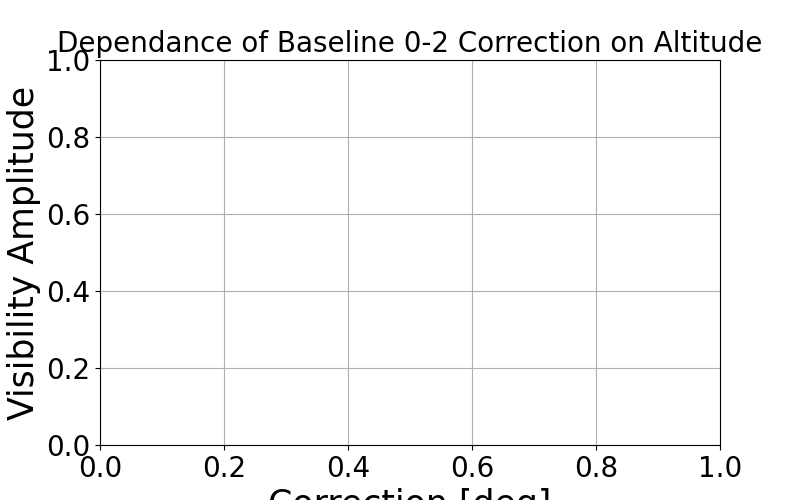

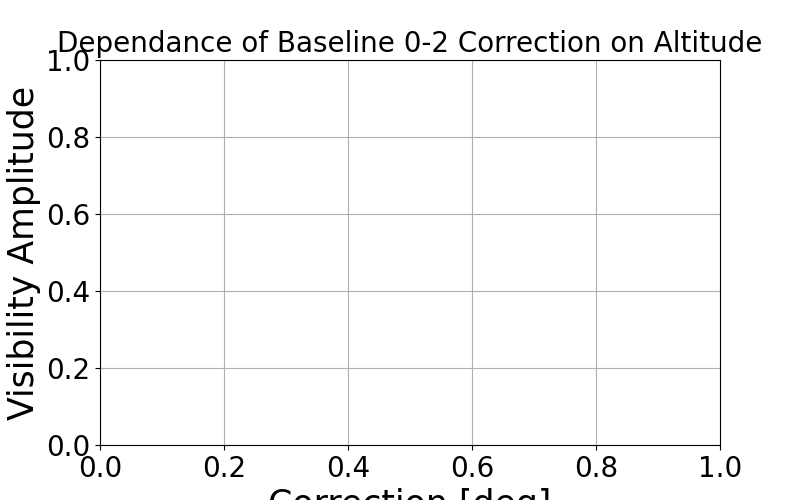

(49, 45)


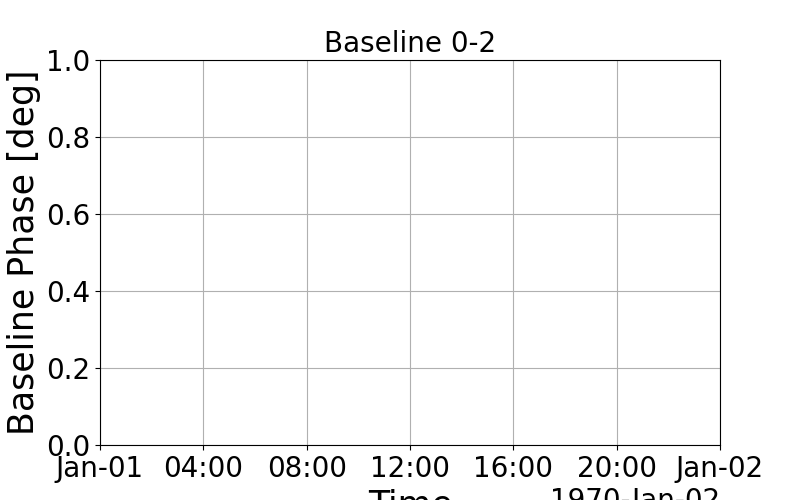

In [29]:
# now, progress through the airplanes, one at a time.
# calculate the expected phase of the airplane on each baseline, and compare it to the
# measured xspectra phase
# also make a sample plot to assist in picking out the good airplanes
plt.close('all')

baseline_to_plot = [0, 2]

fig, ax = plt.subplots()
fig.set_size_inches(fig_width_inches, fig_height_inches)
ax.set_ylabel('Baseline Phase [deg]')
ax.set_xlabel('Time')
ax.set_title(f'Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]}')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid()

fig2, ax2 = plt.subplots()
fig2.set_size_inches(fig_width_inches, fig_height_inches)
ax2.set_ylabel('Visibility Amplitude')
ax2.set_xlabel('Correction [deg]')
ax2.set_title(f'Dependance of Baseline {baseline_to_plot[0]}-{baseline_to_plot[1]} Correction on Altitude')
ax2.grid()

total_phases = []
total_phase_slopes = []
total_amplitudes = []
total_self_amps = []
total_flights = []

db_index = 0
for db in aircrafts_dbs:
    phases_this_timeframe = []
    phase_slopes_this_timeframe = []
    amplitudes_this_timeframe = []
    self_amps_this_timeframe = []
    flights_this_timeframe = []
    if db == None:
        continue
    for index, flight in enumerate(db): # flight is a single airplane in the timeframe covered by db. the flight times are bounded but not necessarily maximal
        print(f'db: {db_index}\tflight {index}')
        
        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = flight.data.index[0]
        end_idx = flight.data.index[-1]
        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(flight.data.latitude, flight.data.longitude, flight.data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)
        az = -az + 90 # convert to NORTH OF East angles

        this_airplane_db_time = flight.data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
        
        # now, we compare this airplane data to baseline data
        this_airplane_echo_indices = np.isin(airplane_echo_time, this_airplane_db_time)
        this_airplane_xspectra = airplane_xspectra[this_airplane_echo_indices, :]
        this_airplane_spectra = airplane_spectra[this_airplane_echo_indices, :]
        this_airplane_echo_time = airplane_echo_time[this_airplane_echo_indices]

        phases_this_airplane = [] # a full set of baseline corrections from a single airplane
        phase_slopes_this_airplane = [] # the slope of the line of best fit (not horizontal) of the phase data for this airplane
        amplitudes_this_airplane = [] # the average amplitude of the xspectra from a single airplane (multiple range-dopp == multiple xspectra) 
        self_amps_this_airplane = [] # the average amplitude of the spectra from a single airplane (multiple range-dopp == multiple spectra) 
        baseline = 0

        this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
        this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

        for antenna1 in range(10):
            # self spectra
            self_amps_series = []
            for k in range(len(this_airplane_db_timestamps)):
                visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]
                self_amps_series.append(np.abs(this_airplane_spectra[visibility_indices, antenna1]))

            self_amps_series = np.hstack(self_amps_series)
            self_amps_this_airplane.append(np.mean(self_amps_series))
            
            for antenna2 in range(antenna1+1, 10):
                #"""
                # use the more flexible complex approach
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_unit_vector = np.exp(1j * expected_phase)
                
                # for each timestamp, take all range-doppler bins with data and compute difference between the visibility value phase and the expected phase
                phase_shift_series = []
                phase_shift_times = []
                amplitudes_series = []
                for k in range(len(this_airplane_db_timestamps)):
                    visibility_indices = this_airplane_echo_timestamps == this_airplane_db_timestamps[k]

                    # do the complex multiplication
                    phase_shifts = np.rad2deg(np.angle(np.conjugate(expected_unit_vector[k]) * this_airplane_xspectra[visibility_indices, baseline]))
                    phase_shift_series.append(phase_shifts)
                    amplitudes_series.append(np.abs(this_airplane_xspectra[visibility_indices, baseline]))
                    
                    # generate the time array needed to plot this
                    for m in range(phase_shifts.shape[0]):
                        phase_shift_times.append(this_airplane_db_timestamps[k])

                phase_shift_series = np.hstack(phase_shift_series)
                phase_shift_times = np.hstack(phase_shift_times)
                amplitudes_series = np.hstack(amplitudes_series)

                # find the best fitting horizontal line (slope zero)
                # this is equivalent to the angular mean, which takes into account phase wrapping
                mean_shift, stdev = ap.angular_mean_and_stdev(np.deg2rad(phase_shift_series))
                b_data = (np.rad2deg(mean_shift),)
                S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                #b_data, residuals = ap.linear_regression_with_known_slope2(phase_shift_times, phase_shift_series, m=0)
                #S = np.sum(np.abs(phase_shift_series - b_data)) / phase_shift_series.shape[0] 
                #R2 = 1 - residuals / (phase_shift_series.shape[0] * phase_shift_series.var())

                # do linear regression on the data (obtain non-zero slope)
                m, _ = np.polyfit(phase_shift_times, phase_shift_series, deg=1)

                
                phase_slopes_this_airplane.append(m)
                
                #phases_this_airplane.append(np.rad2deg(ap.angular_mean_and_stdev(np.deg2rad(phase_shift_series))[0]))
                #phases_this_airplane.append(b_data[0])

                # need to find a way to make these magic numbers baseline dependent
                # median of current S values? ensures at least one value
                #if S <= 50 and S >= 1.0:
                phases_this_airplane.append(b_data[0])
                amplitudes_this_airplane.append(np.mean(amplitudes_series))
                # if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                #     ax2.scatter(b_data[0]%360, np.mean(flight.data.altitude * FT_TO_M)/1000, c='r')
                #     ax2.scatter(np.mean(amplitudes_series), np.mean(flight.data.altitude * FT_TO_M)/1000, c='g')
                #     ax2.scatter(np.median(amplitudes_series), np.mean(flight.data.altitude * FT_TO_M)/1000, c='blue')
                #     ax.scatter(vfromtimestamp(phase_shift_times), phase_shift_series, c='tab:orange')
                #     ax.plot(vfromtimestamp([phase_shift_times[0], phase_shift_times[-1]]), [b_data, b_data], c='tab:blue') 
                #     ax.annotate(f'S={S:.2f}', (vfromtimestamp(phase_shift_times)[0], phase_shift_series[0]), annotation_clip=False, fontsize=20)
                #     try:
                #         ax.annotate(f'cor={b_data[0]:.2f}', (vfromtimestamp(phase_shift_times)[3], phase_shift_series[3]), annotation_clip=False, fontsize=20)
                #     except:
                #         print('')
                #else:
                #    phases_this_airplane.append(np.nan)
                #    amplitudes_this_airplane.append(np.nan)

                #print(amplitudes_this_airplane[-1])
                #print(phases_this_airplane[-1])
                
                """
                # The old, more intuitive and less flexible way of doing things
                
                # obtain the expected phase of the airplane on the baseline based on the airplane GPS
                expected_phase = ap.calculate_baseline_phase(antenna1, antenna2, az, el)
                expected_phase = np.rad2deg(expected_phase)

                # obtain the relevant baseline visibility
                vis_phase = np.rad2deg(np.angle(this_airplane_xspectra[:, baseline]))
                
                # unwrap the visibility phase
                tol = 45
                n_median = 3
                vis_phase_saved = vis_phase
                vis_phase = ap.unwrap_phase(vis_phase, tol=tol)
                
                #v1 = vis_phase
                # i mean, this isn't feasible. it has to be done for EVERY BASELINE
                #vis_phase = manually_adjust_phase(vis_phase, year, month, day, airplane_idx)
                #v2 = vis_phase
                #print(v1 == v2)
                
                # calculate a linear best fit for the expected airplane baseline phase 
                this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())
                m, b_plane = np.polyfit(this_airplane_db_timestamps, expected_phase, deg=1)
                
                # using the slope of that best fit, do least squares regression on the measured data
                # this will find the y-intercept that best matches the measured data to a line with the slope m
                this_airplane_echo_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_echo_time)
                b_data, residuals = ap.linear_regression_with_known_slope2(this_airplane_echo_timestamps, vis_phase, m)
                R2 = 1 - residuals / (vis_phase.shape[0] * vis_phase.var())

                # plot the best fit line for the predicted baseline phase
                x = np.array([this_airplane_db_timestamps[0], this_airplane_db_timestamps[-1]])
                y = m * x + b_plane
                y1 = y
                x = vfromtimestamp(x)
                #ax.plot(x, y, c='black')
                
                # plot the measured visibility phase and it's best fit line                
                #if np.all(vis_phase) != 0:

                x = np.array([this_airplane_echo_timestamps[0], this_airplane_echo_timestamps[-1]])
                y = m * x + b_data
                y2 = y
                correction = (y2-y1)[0]
                x = vfromtimestamp(x) # don't use vutcfromtimestamp here because the data is already in utc

                if antenna1 == baseline_to_plot[0] and antenna2 == baseline_to_plot[1]:
                    ax.plot(x, y-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase_saved-correction, c='tab:blue')
                    ax.scatter(vfromtimestamp(this_airplane_echo_timestamps), vis_phase-correction, c='tab:orange')
                    ax.scatter(vfromtimestamp(this_airplane_db_timestamps), expected_phase, c='black')
                    ax.annotate(f'{airplane_idx}', (vfromtimestamp(this_airplane_db_timestamps)[0], expected_phase[0]), annotation_clip=False, fontsize=30)
                    ax.annotate(f'R2={R2[0]:.2f}', (vfromtimestamp(this_airplane_db_timestamps)[-1], expected_phase[-1]), annotation_clip=False, fontsize=20)

                # record the correction for this baseline
                phases_this_airplane.append(correction)
                #"""
                baseline += 1

        phases_this_airplane = np.array(phases_this_airplane)
        phases_this_timeframe.append(phases_this_airplane)

        phase_slopes_this_airplane = np.array(phase_slopes_this_airplane)
        phase_slopes_this_timeframe.append(phase_slopes_this_airplane)

        amplitudes_this_airplane = np.array(amplitudes_this_airplane)
        amplitudes_this_timeframe.append(amplitudes_this_airplane)   
        
        self_amps_this_airplane = np.array(self_amps_this_airplane)
        self_amps_this_timeframe.append(self_amps_this_airplane)

        flights_this_timeframe.append(index)
    
    phases_this_timeframe = np.array(phases_this_timeframe)
    total_phases.append(phases_this_timeframe)
    
    phase_slopes_this_timeframe = np.array(phase_slopes_this_timeframe)
    total_phase_slopes.append(phase_slopes_this_timeframe)
    
    amplitudes_this_timeframe = np.array(amplitudes_this_timeframe)
    total_amplitudes.append(amplitudes_this_timeframe)

    self_amps_this_timeframe = np.array(self_amps_this_timeframe)
    total_self_amps.append(self_amps_this_timeframe)

    flights_this_timeframe = np.array(flights_this_timeframe)
    total_flights.append(flights_this_timeframe)
    
    db_index += 1


# for each timeframe, remove the non-ideal airplanes as determined by the phase slopes
filtered_corrections = []
filtered_amplitudes = []
filtered_self_amps = []
flights_to_keep = []
for i in range(len(total_phase_slopes)):
    slopes_this_timeframe = total_phase_slopes[i]
    phases_this_timeframe = total_phases[i]
    amplitudes_this_timeframe = total_amplitudes[i]
    self_amps_this_timeframe = total_self_amps[i]
    flights_this_timeframe = total_flights[i]
    
    if slopes_this_timeframe.shape[0] == 0:
        continue
    else:
        # for each baseline in this timeframe, examine the slopes. After examining each baseline,
        # choose the airplane index at which the majority of baselines have a minimum slope.
        # use the correction and amplitude values at that slope and remove the rest.
        minimum_slope_indices = []
        baseline = 0 
        for antenna1 in range(10):
            for antenna2 in range(antenna1+1, 10):
                slopes = slopes_this_timeframe[:, baseline]

                # find the index where the slope is the minimum slope for this baseline
                # since this should correspond to a particular airplane, we expect this index to 
                # be constant across baseline.
                try:
                    minimum_slope_idx = np.nanargmin(np.abs(slopes))
                    minimum_slope_indices.append(minimum_slope_idx)
                except:
                    continue
                baseline += 1

        # sometimes the ICEBAER data is full of nans, so the above expection will trigger on each baseline and 
        # minimum_slope_indices will be empty. Just skip it
        if minimum_slope_indices == []:
            continue

        # find which airplane shows up as the "best" most often in the timeframe
        unique, counts = np.unique(minimum_slope_indices, return_counts=True)
        print(unique[0], counts[0])

        # only take the corrections and amplitudes that correspond to the best airplane
        if counts[0] > 25:
            filtered_corrections.append(phases_this_timeframe[unique[0], :]) 
            filtered_amplitudes.append(amplitudes_this_timeframe[unique[0], :])
            filtered_self_amps.append(self_amps_this_timeframe[unique[0], :])
            flights_to_keep.append(unique[0])
            
total_phases = np.vstack(filtered_corrections)
total_amplitudes = np.vstack(filtered_amplitudes)
total_self_amps = np.vstack(filtered_self_amps)

# remove the airplanes from the aircrafts_dbs as well (if using an aircraft file appended with '-unique', this step is already performed)
if not unique_filtered:
    index_into_flights_to_keep = 0 
    for db in aircrafts_dbs:
        if db == None:
            continue
    
        made_it_in_and_gt1_plane = False
        for flight_index, flight in enumerate(db): # flight is a single airplane in the timeframe covered by db. the flight times are bounded but not necessarily maximal
            if flight_index >= 1:
                made_it_in_and_gt1_plane = True
            if flight_index != flights_to_keep[index_into_flights_to_keep]:
                print('here')
                db.drop(index=db.data['icao24'][db.data['icao24'] == str(flight.icao24)].index, inplace=True)
                
        if made_it_in_and_gt1_plane:
            index_into_flights_to_keep += 1
    
    ap.save_aircrafts_dbs(aircrafts_dbs, f'{year:04d}-{month:02d}-{day:02d}-unique', filtered=True)


# make the legend
"""
custom_lines = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='black', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:blue', markersize=12),
                Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='tab:orange', markersize=12),
                Line2D([0], [0], color='tab:orange', lw=4)]

ax.legend(custom_lines, ['expected phase', 'corrected measured phase (wrapped)', 'corrected measured phase (unwrapped)', 'data best fit (after correction)'])
"""
plt.show(fig)
plt.show(fig2)
print(total_phases.shape)

total_phases_copy = total_phases.copy()
total_amplitudes_copy = total_amplitudes.copy()
total_self_amps_copy = total_self_amps.copy()


In [36]:
total_amplitudes = total_amplitudes_copy.copy()
total_phases = total_phases_copy.copy()
total_self_amps = total_self_amps_copy.copy()

plotting = False
n_corrections = total_phases.shape[0]
if plotting:
    fig, ax = plt.subplots()
    for plane in range(n_corrections):
        ax.scatter(np.arange(45), total_phases[plane, :]%360, c='tab:blue')

averaged_corrections = []
median_corrections = []
stdev_corrections = []

# calculate the mean/median etc. 
for baseline in range(45): # total_phases already has the planes selected from above
    median = ap.angular_median(np.deg2rad(total_phases[:, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_phases[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

if plotting:
    ax.scatter(np.arange(45), averaged_corrections, c='red', label='angular mean')
    ax.scatter(np.arange(45), median_corrections, c='yellow', label='angular median')
    ax.scatter(np.arange(45), stdev_corrections, c='green', label='angular standard dev')
    ax.legend()
    ax.set_title('Before Data Filter')
    ax.grid()
    plt.show()


# amplitude calibration
# the idea:
# the amplitude of a visibility, in general, may be low (or high) due to destructive interference from multiple targets in the sky.
# for an airplane, the overwhelming contribution to the visibility amplitude is KNOWN to be only the airplane.
# therefore, all visibility amplitudes should be "normalised" to an airplane, such that they are equal for the airplane.

# find the visibility with the best (tightest, not least shift) phase response
min_index = np.argmin(stdev_corrections)
baseline = 0
found = False
for i in range(10):
    for j in range(i+1, 10):
        if found:
            continue
        if baseline == min_index:
            found = True
            print(f'normalising amplitude to baseline {i}-{j}, index {min_index}')
        else:
            baseline += 1

# calculate the amplitude ratio between the best phase response baseline and the remaining baselines
median_amplitudes = np.median(total_amplitudes, axis=0)
amplitude_ratio = total_amplitudes / total_amplitudes[:, min_index][:, np.newaxis]
median_amplitude_ratios = np.median(amplitude_ratio, axis=0)

# calculate the amplitude ratio between the reference antenna (dealer's choice) and the remaining antennas
reference_antenna = 1
median_self_amps = np.median(total_self_amps, axis=0)
self_amp_ratio = total_self_amps / total_self_amps[:, reference_antenna][:, np.newaxis]
median_self_amp_ratios = np.median(self_amp_ratio, axis=0)

# sanitise the amplitude and phases: whenever all of the amplitude ratios are about 1, the phase gets completely incoherent.
# these airplanes shouldn't be included in any analysis, so remove them and repeat the process.
n_deleted = 0
for i in range(amplitude_ratio.shape[0]-1, -1, -1):
    if np.all(np.abs(amplitude_ratio[i, :] - 1) < 0.25):
        amplitude_ratio = np.delete(amplitude_ratio, (i), axis=0)
        self_amp_ratio = np.delete(self_amp_ratio, (i), axis=0)
        total_self_amps = np.delete(total_self_amps, (i), axis=0)
        total_phases = np.delete(total_phases, (i), axis=0)
        n_deleted += 1
        
print(f'deleted {n_deleted} nasty airplanes')

# re-calculate the mean/median etc.
averaged_corrections = []
median_corrections = []
stdev_corrections = []

for baseline in range(45): # total_phases already has the planes selected from above
    median = ap.angular_median(np.deg2rad(total_phases[:, baseline]%360))
    mean, stdev = ap.angular_mean_and_stdev(np.deg2rad(total_phases[:, baseline]))
    averaged_corrections.append(np.rad2deg(mean))
    median_corrections.append(np.rad2deg(median))
    stdev_corrections.append(np.rad2deg(stdev))

averaged_corrections = np.array(averaged_corrections)
averaged_corrections[averaged_corrections < 0] += 360

median_corrections = np.array(median_corrections)
stdev_corrections = np.array(stdev_corrections)

print(median_corrections)

normalising amplitude to baseline 1-3, index 10
deleted 7 nasty airplanes
[ 12.97789167 303.18501281 355.90219456 102.92574989 323.01689507
  20.33884116 342.39379665 339.53064897 223.70453549 304.72847378
 338.74665475  93.56407057 317.05167978   2.13733423 327.65678856
 326.46605542 212.0499676   49.97075048 162.51510429  23.09780624
  66.27182204  27.11476027  37.18762489 281.09144215 111.53598462
 329.97545634  19.11448899 350.80677082 345.15465908 231.71699464
 226.51223762 267.74342576 229.42377769 232.12778358 115.6236001
  46.25409457   9.65909406  15.65750678 256.37910579 315.26843118
 324.57526652 212.94295894 355.77885864 248.14277334 246.83084662]


In [198]:
# generate antenna based calibrations

# sum the standard deviations of phase corrections for each antenna. take the smallest number as the "best" antenna
sum_stdev = np.zeros(10)
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        sum_stdev[antenna1] += stdev_corrections[baseline]
        sum_stdev[antenna2] += stdev_corrections[baseline]
        baseline += 1
        
best_antenna = np.argmin(sum_stdev)
print(f'best antenna = {best_antenna}')

# use the star pattern from the best antenna:
antenna_phase_corrections = np.zeros(10)
antenna_phase_corrections[best_antenna] = 0

antenna_amp_corrections = 1 / median_self_amp_ratios

baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        if antenna1 == best_antenna:
            antenna_phase_corrections[antenna2] = -median_corrections[baseline]
        elif antenna2 == best_antenna:
            antenna_phase_corrections[antenna1] = median_corrections[baseline]
        baseline += 1

print(antenna_phase_corrections)
print(antenna_amp_corrections)

antenna_based_vis_corr = np.zeros(45)
antenna_based_amp_corr = np.zeros(45)
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        antenna_based_vis_corr[baseline] = antenna_phase_corrections[antenna1] - antenna_phase_corrections[antenna2]
        antenna_based_amp_corr[baseline] = antenna_amp_corrections[antenna1] * antenna_amp_corrections[antenna2]
        baseline += 1

best antenna = 9
[241.66489294 215.66060448 274.17106075 255.18506584 121.70722135
 233.36262129 224.57030877 264.16933702 257.77821641   0.        ]
[1.0526669  1.         0.83481586 0.56255746 0.9509168  1.1028218
 1.4407881  0.47295612 0.5235538  0.65554154]


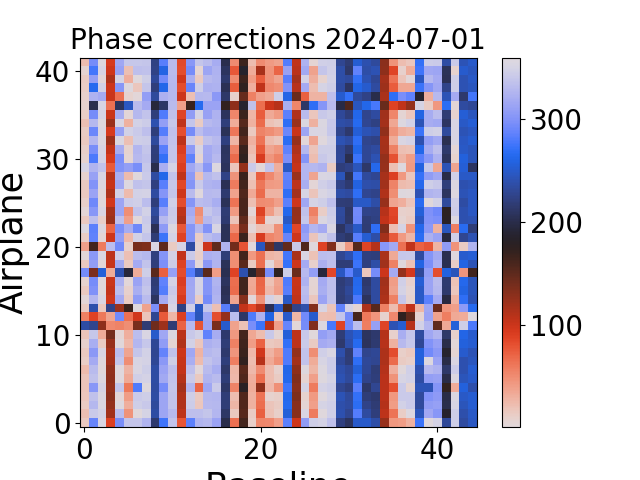

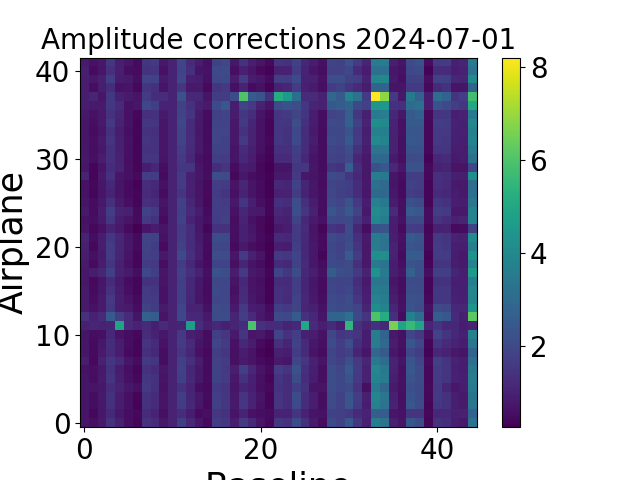

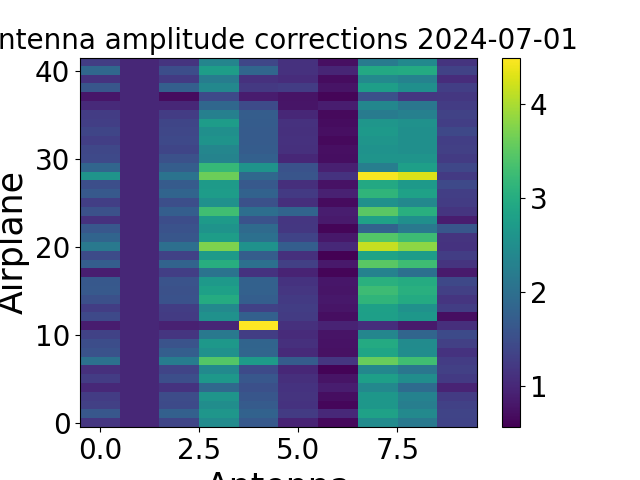

In [31]:
# compare results of visibility-based corrections to antenna-based corrections
# or use the commmented lines to just examine visibility calibrations on their own.

# phase correction
fig, ax = plt.subplots()
#cmap = ax.imshow((total_phases - antenna_based_vis_corr)%360 , origin='lower', aspect='auto', cmap=plt.get_cmap("cet_cyclic_wrkbw_10_90_c43"))
cmap = ax.imshow(total_phases%360 , origin='lower', aspect='auto', cmap=plt.get_cmap("cet_cyclic_wrkbw_10_90_c43"))
ax.set_xlabel('Baseline')
ax.set_ylabel('Airplane')
ax.set_title(f'Phase corrections {year:04d}-{month:02d}-{day:02d}')# - antenna corrections')
fig.colorbar(cmap)
plt.show(fig)

# amplitude correction
fig, ax = plt.subplots()
#cmap = ax.imshow(amplitude_ratio - 1 / antenna_based_amp_corr, origin='lower', aspect='auto')
cmap = ax.imshow(amplitude_ratio, origin='lower', aspect='auto')
ax.set_xlabel('Baseline')
ax.set_ylabel('Airplane')
ax.set_title(f'Amplitude corrections {year:04d}-{month:02d}-{day:02d}')
fig.colorbar(cmap, ax=ax)
plt.show(fig)

# self-spectra amplitudes
fig, ax = plt.subplots()
cmap = ax.imshow(self_amp_ratio, origin='lower', aspect='auto')
ax.set_xlabel('Antenna')
ax.set_ylabel('Airplane')
ax.set_title(f'Antenna amplitude corrections {year:04d}-{month:02d}-{day:02d}')
fig.colorbar(cmap, ax=ax)
plt.show(fig)

In [32]:
print(np.mean(self_amp_ratio[:, 0]))
print(year, month, day)

1.4453837
2024 7 1


In [33]:
# save the phase corrections
np.save(f'median_corrections_{year:04d}-{month:02d}-{day:02d}.npy', median_corrections)

# save full complex corrections
complex_corrections = (1 / np.mean(amplitude_ratio, axis=0)) * np.exp(-1j * np.deg2rad(median_corrections))
np.save(f'complex_corrections_{year:04d}-{month:02d}-{day:02d}.npy', complex_corrections)

#np.savetxt("complex_corrections_2024-09-20.csv", complex_corrections, delimiter=",")

In [ ]:
# Level 2 data will now have to be processed before continuing

In [ ]:
# inputs to the second part of the script:
# level2_files - the result of processing the uncalibrated level 1 data to level 2 data using the baseline calibrations
#                found in the previous cell. 
level2_files = []
#level2_files.append(f'/mnt/NAS/airplane-data/L2_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # without relaxation

#level2_files.append(f'/mnt/NAS/airplane-data/L2-Scal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
level2_files.append(f'/mnt/NAS/airplane-data/L2-standardcal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-no-cal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-manual-cal/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated
#level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth-median_1/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated

#level2_files.append(f'/mnt/NAS/airplane-data/L2-median-calibrated/{year}/{month:02d}/{year}_{month:02d}_{(day):02d}/ib3d_normal_swht_{year}_{month:02d}_{(day):02d}_prelate_bakker.h5') # non airplane calibrated


In [ ]:
# plot up the level 2 data and the corresponding airplane data
fig_az, ax_az = plt.subplots()
fig_az.set_size_inches(fig_width_inches, fig_height_inches)
ax_az.set_ylabel('Azimuth [deg]')
ax_az.set_xlabel('Time')
ax_az.set_title(f'Azimuth')
ax_az.xaxis.set_major_locator(locator)
ax_az.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_azel, ax_azel = plt.subplots()
fig_azel.set_size_inches(fig_width_inches, fig_height_inches)
ax_azel.set_ylabel('Elevation [deg]')
ax_azel.set_xlabel('Azimuth [deg]')
ax_azel.set_title(f'Azimuth/Elevation')
# plot the allowed az/el polygon (wrt boresight)
az = np.load('allowed_airplane_azimuth.npy')
az = np.where(az > 180.0, az - 360.0, az)
el = np.load('allowed_airplane_elevation.npy')
ax_azel.scatter(az, el, c='red')
ax_azel.legend(['allowed airplane AoAs'])

fig_els, ax_els = plt.subplots()
fig_els.set_size_inches(fig_width_inches, fig_height_inches)
ax_els.set_ylabel('True Elevation [deg]')
ax_els.set_xlabel('Measured Elevation - True Elevation [deg]')
ax_els.set_title(f'Error in Elevation')

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)

    #range_filter = (rf_distance < 256) & (rf_distance > 246)
    #else:
    #range_filter = (rf_distance < 301) & (rf_distance > 291)
    range_filter = (rf_distance < 301) & (rf_distance > 246)
        
    # plot az and el / time
    ax_az.scatter(utc_time[range_filter], azimuth[range_filter])
    ax_el.scatter(utc_time[range_filter], elevation[range_filter])
    
    # plot az/el
    ax_azel.scatter(azimuth[range_filter], elevation[range_filter])
    
    f.close()

aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
plane_indices = [1,3,9,12,16,34,53,67,106,109,123,127,132,139,141,143,150,152,182] # 12/12/2020
plane_indices = []
airplane_idx = 0

el_difference = []
true_el = []
for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
        
    # db[i].data.long/lat is the time series of data for one airplane (i)
    
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.

        if airplane_idx not in plane_indices:
            plane_indices.append(airplane_idx)
            airplane_idx += 1
            #continue

        # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]

        # using the indexes, find the start and end times of the airplane
        ti = db[i].data.timestamp[start_idx]
        ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        tf = tf.replace(tzinfo=None)

        
        # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
        # this azimuth is measured EAST OF NORTH
        az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
        # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
        az = np.where(az > 180.0, az - 360.0, az)

        this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)

        # level 2 data filtered by time
        for k in range(this_airplane_db_time.shape[0]):
            index = this_airplane_db_time.index[k]
            l2_el = elevation[utc_time == this_airplane_db_time[index].to_pydatetime().replace(tzinfo=None)]
            el_difference.append(l2_el - el[index])
            for m in range(l2_el.shape[0]):
                true_el.append(el[index])
            
        # plot az and el
        ax_el.scatter(this_airplane_db_time, el, c='black')
        ax_az.scatter(this_airplane_db_time, az, c='black')
        ax_azel.scatter(az, el, c='black')

        airplane_idx += 1

true_el = np.hstack(true_el)
el_difference = np.hstack(el_difference)

#ax_els.hist(el_difference, bins=[-6+i*0.2 for i in range(50)])
ax_els.scatter(el_difference, true_el)

plt.show()


In [ ]:
# perform manual geolocation of the echoes using AoA
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig_ll, ax_ll = plt.subplots()
fig_ll.set_size_inches(fig_width_inches, fig_height_inches)
ax_ll.set_ylabel('Latitude [deg]')
ax_ll.set_xlabel('Longitude [deg]')
ax_ll.set_title(f'Airplane tracks and ICEBEAR echoes - {year:04}-{month:02d}-{day:02d}')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_ll.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_ll.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_ll.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
#ax_ll.set_xlim([-109.8, -105.8])
#ax_ll.set_ylim([50, 53])
ax_ll.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'])

fig_alt, ax_alt = plt.subplots()
fig_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_alt.set_ylabel('Altitude [km]')
ax_alt.set_xlabel('Time')
ax_alt.set_title(f'Altitude vs. Time - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation vs. Time - {year:04}-{month:02d}-{day:02d}')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_lon_alt, ax_lon_alt = plt.subplots()
fig_lon_alt.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_alt.set_ylabel('Altitude [km]')
ax_lon_alt.set_xlabel('Longitude [deg]')
ax_lon_alt.set_title(f'Altitude vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_alt.xaxis.set_major_locator(locator)
#ax_lon_alt.xaxis.set_major_formatter(formatter)

fig_lon_el, ax_lon_el = plt.subplots()
fig_lon_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_lon_el.set_ylabel('Elevation [deg]')
ax_lon_el.set_xlabel('Longitude [deg]')
ax_lon_el.set_title(f'Elevation vs. Longitude - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

fig_errel, ax_errel = plt.subplots()
fig_errel.set_size_inches(fig_width_inches, fig_height_inches)
ax_errel.set_ylabel('Error in Elevation [deg]')
ax_errel.set_xlabel('Azimuth [deg]')
ax_errel.set_title(f'Error in Elevation vs. Radar Azimuth - {year:04}-{month:02d}-{day:02d}')
#ax_lon_el.xaxis.set_major_locator(locator)
#ax_lon_el.xaxis.set_major_formatter(formatter)

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)
    echo_timestamps = ap.datetime_to_seconds_since_epoch(utc_time)
    

    range_filter = (rf_distance < 256) & (rf_distance > 246)
    #range_filter = (rf_distance < 301) & (rf_distance > 291)

    # calculate the slant range from ICEBEAR data
    # rho_rf = (rf_distance[range_filter] - 45) * 1.0e3
    # find_kappa(rho_rf, azimuth, elevation, range_filter)
    
    
    # # calculate slant range
    # print(rho_rf[0:10])
    # print(rho_d)
    # print(cos_kappa)
    # slant_range = (rho_rf ** 2 - rho_d ** 2) / (2 * (rho_rf - rho_d * cos_kappa))
    # print(slant_range)

    # # from slant range and az/el, map the target in lat/lon/alt
    # lat, lon, alt = pm.aer2geodetic(azimuth[range_filter], elevation[range_filter], slant_range,
    #                           np.repeat(RX[0], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[1], azimuth[range_filter].shape[0]),
    #                           np.repeat(RX[2], azimuth[range_filter].shape[0]),
    #                           ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            

    
    # also load in the aircraft data for this day
    aircrafts_dbs = ap.load_airplane_data(f'aircrafts_dbs_{year:04d}-{month:02d}-{day:02d}.pckl')
            
    elevation_error = []
    azimuths_to_plot = []
    
    # now, loop through all airplanes in this day, and for each valid airplane, find kappa using the airplanes true dist from receiver
    airplane_idx = 0
    for db in aircrafts_dbs:

        # db is a database of every airplane in the timeframe.
        if db == None:
            continue
            
        # db[i].data.long/lat is the time series of data for one airplane (i)
        
        for i in range(len(db)): # db[i] is a single airplane in the timeframe.
    
            # indexes in db continue multiple airplanes, so need to manually find the indices for this airplane
            start_idx = db[i].data.index[0]
            end_idx = db[i].data.index[-1]
    
            # using the indexes, find the start and end times of the airplane
            ti = db[i].data.timestamp[start_idx]
            ti = ti.replace(tzinfo=None)
            tf = db[i].data.timestamp[end_idx]
            tf = tf.replace(tzinfo=None)
            
            
            # from the airplane's geographic latitude/longitude/altitude, find the azimuth/elevation/altitude of the airplane from the receiver
            # this azimuth is measured EAST OF NORTH
            az, el, slant_range = ap.find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude * FT_TO_M)
            # still east of north, but adjusted to be -180 to 180 instead of 0 to 360
            az = np.where(az > 180.0, az - 360.0, az)
            az = -az + 90 # convert to NORTH OF East angles
    
            # narrow the geographic bounds
            if np.any(db[i].data.latitude > 52.25) \
                or np.any(db[i].data.longitude > -106.5) \
                or np.any(db[i].data.longitude < -109.0) \
                or np.all(el > 25) \
                or np.all(90 - az < -128) \
                or np.all(90 - az > -122):
                #or np.all(az < 180)
                #or np.all(az > 270)
            
                airplane_idx += 1
                continue
    
            this_airplane_db_time = db[i].data.timestamp[:] # .to_pydatetime().replace(tzinfo=timezone.utc)
            this_airplane_db_timestamps = ap.datetime_to_seconds_since_epoch(this_airplane_db_time.dt.to_pydatetime())

            repeated_slant_range = []
            overall_time_filter = np.zeros(time.shape)
            for k in range(this_airplane_db_time.shape[0]):
                idx = db[i].data.index[k]
                time_filter = time * 1.0 == this_airplane_db_timestamps[k]
                time_filter = range_filter & time_filter
                repeated_slant_range.append(np.repeat(slant_range[idx], np.count_nonzero(time_filter)))#azimuth[time_filter].shape[0]))
                
                overall_time_filter = np.logical_or(overall_time_filter, time_filter)
                
                elevation_error.append(np.abs(el[idx] - elevation[time_filter]))
                azimuths_to_plot.append(azimuth[time_filter])

            
            repeated_slant_range = np.hstack(repeated_slant_range)
            #time_filter = (range_filter) & (overall_time_filter)
            time_filter = overall_time_filter

            
            # from slant range and az/el, map the target in lat/lon/alt
            lat, lon, alt = pm.aer2geodetic(azimuth[time_filter], elevation[time_filter], repeated_slant_range,
                                       np.repeat(RX[0], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[1], azimuth[time_filter].shape[0]),
                                       np.repeat(RX[2], azimuth[time_filter].shape[0]),
                                       ell=pm.Ellipsoid.from_name("wgs84"), deg=True)
            
            # plot lat/lon
            ax_ll.scatter(lon, lat)
            ax_ll.scatter(db[i].data.longitude, db[i].data.latitude, c='black')

            # altitude time
            ax_alt.scatter(utc_time[time_filter], alt/1000)
            ax_alt.scatter(this_airplane_db_time, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            # elevation time
            ax_el.scatter(utc_time[time_filter], elevation[time_filter])
            try:
                ax_el.scatter(utc_time[time_filter][utc_time[time_filter].shape[0]//2], np.mean(elevation[time_filter]), marker='*', c='black')
            except:
                print('oops')
            ax_el.scatter(this_airplane_db_time, el, c='black')

            # altitude longitude
            ax_lon_alt.scatter(lon, alt/1000)
            ax_lon_alt.scatter(db[i].data.longitude, db[i].data.altitude * FT_TO_M / 1000, c='black')

            # elevation longitudel
            ax_lon_el.scatter(lon, elevation[time_filter])
            ax_lon_el.scatter(db[i].data.longitude, el, c='black')

            # elevation error azimuth
            #ax_errel.scatter(azimuths_to_plot, elevation_error)
            
            # altitude azimuth
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            #ax_alt.scatter(90-az, db[i].data.altitude * FT_TO_M / 1000, c='black')
            
            #ax_alt.scatter(azimuth[time_filter], alt/1000)
            airplane_idx += 1
        

    elevation_error = np.hstack(elevation_error)
    azimuths_to_plot = np.hstack(azimuths_to_plot)
    xedges=np.arange(-130, -122, 0.2)
    yedges=np.arange(0, 9, 0.1)
    H, xedges, yedges = np.histogram2d(azimuths_to_plot, elevation_error, bins=(xedges,yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax_errel.pcolormesh(X, Y, H.T)
            

    f.close()

In [ ]:
# compare calibration values
dates = [ (2021,3,1),
         (2021,3,20),
         (2021,10,1),
         (2022,8,8),
         (2022,12,12),
         (2022,12,13),
         (2022,12,14),
         (2022,12,15),
        ]

calibration_files = []
plot_dates = []
for date in dates:
    yy = date[0]
    mm = date[1]
    dd = date[2]
    calibration_files.append(f'median_corrections_{yy:04d}-{mm:02d}-{dd:02d}.npy')
    plot_dates.append(datetime.datetime(yy, mm, dd))
    
fig, ax = plt.subplots()
for baseline in range(45):
    cals = []
    for file in calibration_files:
        cal = np.load(file)
        cals.append(cal[baseline])
    ax.plot(plot_dates, cals)

plt.show(fig)


In [ ]:
# compare manual calibration to airplane calibration for 2022-12-13
manual_calibrations = [0,
                       -19.805,
                       -22.595,
                       -22.17,
                       -35.42,
                       9.570,
                       9.940,
                       -5.565,
                       2.070,
                       18.095
                      ]

manual_baseline_calibrations = []
baseline = 0
for antenna1 in range(10):
    for antenna2 in range(antenna1+1, 10):
        if antenna1 == 9:
            manual_baseline_calibrations.append(-manual_calibrations[antenna1] - manual_calibrations[antenna2])
        elif antenna2 == 9:
            manual_baseline_calibrations.append(manual_calibrations[antenna1] + manual_calibrations[antenna2])
        else:
            manual_baseline_calibrations.append(manual_calibrations[antenna1] - manual_calibrations[antenna2])
        baseline += 1

manual_baseline_calibrations = np.array(manual_baseline_calibrations)

fig, ax = plt.subplots()
ax.set_xlabel('Baseline')
ax.set_ylabel('Calibration: Manual - Airplane [deg]')
ax.plot(np.arange(45), manual_baseline_calibrations)# - manual_baseline_calibrations[0])

for i in range(4):
    match i:
        case 0:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-12.npy')
        case 1:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-13.npy')
        case 2:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-14.npy')
        case 3:
            airplane_baseline_calibrations = np.load(f'median_corrections_2022-12-15.npy')

    airplane_baseline_calibrations *= -1 # these are subtracted off the xspectra phase while the manual calibrations are added. use negative for comparison
    airplane_baseline_calibrations[airplane_baseline_calibrations < -180] += 360
    #airplane_baseline_calibrations -= airplane_baseline_calibrations[0]

    
    ax.plot(np.arange(45), airplane_baseline_calibrations)# - airplane_baseline_calibrations[0])
    #for baseline in range(45):
        
    #    print(f'baseline {baseline}')
    #    print(f'\tmanual:{manual_baseline_calibrations[baseline]}')
    #    print(f'\tairplane:{airplane_baseline_calibrations[baseline]}')
plt.show(fig)

In [ ]:
total_amplitudes_old = total_amplitudes.copy()

In [ ]:
year = 2024
month = 12
day = 13


complex_corrections = np.load(f'complex_corrections_{year:04d}-{month:02d}-{day:02d}.npy')
print(np.abs(complex_corrections))
f = h5py.File(f'/home/ibp2/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')
for key in f['data'].keys():
    if not f['data'][key]['data_flag'][:]:
        continue
    xspectra = f['data'][key]['xspectra'][:]
    corrected_xspectra = xspectra * complex_corrections
    f['data'][key]['xspectra'][...] = corrected_xspectra

f.close()

f = h5py.File(f'/home/ibp2/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')
f2 = h5py.File(f'/mnt/NAS/range-corrected-data/L1-no-cal/{year:04d}/{month:02d}/{year:04d}_{month:02d}_{day:02d}/ib3d_normal_01dB_1000ms_{year:04d}_{month:02d}_{day:02d}_00_prelate_bakker.h5', 'r+')

printed = False
for key in f['data'].keys():
    if not f['data'][key]['data_flag'][:]:
        continue
    corrected_xspectra = f['data'][key]['xspectra'][:]
    old_xspectra = f2['data'][key]['xspectra'][:]
    if not printed:
        print(np.abs(corrected_xspectra) / np.abs(old_xspectra))
        printed = True
        
f.close()
f2.close()